Discussed this assignment with Sang Hoon Kim, Hyun In Park, and Heeseung Hwang.

This is re-organization (and some modification) of the originally provided code so that the flow of code matches the flow of task.  
This is a slightly edited version of the previous submission (codes and results themselves are not changed.)


**Preliminary setup:**

In [10]:
import torch
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [11]:
def get_mnist():

    data=np.float64(np.load('MNIST.npy'))
    labels=np.float32(np.load('MNIST_labels.npy'))
    data=np.float32(data)/255
    
    train_dat=data[0:50000].reshape((-1,1,28,28))
    train_labels=np.int32(labels[0:50000])
    val_dat=data[50000:60000].reshape((-1,1,28,28))
    val_labels=np.int32(labels[50000:60000])
    test_dat=data[60000:70000].reshape((-1,1,28,28))
    test_labels=np.int32(labels[60000:70000])
    
    return (train_dat, train_labels), (val_dat, val_labels), (test_dat, test_labels)

In [12]:
class MNIST_Net(nn.Module):
    '''
    Edited the original codes so that I can pass down feature numbers as parameters
    '''
    def __init__(self, param, p=0.5,minimizer='Adam'):
        
        super(MNIST_Net, self).__init__()
        
        self.param = param
        self.conv1 = nn.Conv2d(param[0], param[1], kernel_size=5)
        self.conv2 = nn.Conv2d(param[1], param[2], kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p)
        
        self.fc1 = nn.Linear(param[3], param[4])
        self.fc2 = nn.Linear(param[4], param[5])
        
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
            
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
            
        self.first=True
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.param[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x
    
    def get_acc_and_loss(self, data, targ):

        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

In [13]:
def run_epoch(net,epoch,train,batch_size, num=None, ttype="train"):

    net.train()
    
    if ttype=='train':
        t1=time.time()
        n=train[0].shape[0]
        
        if (num is not None):
            n=np.minimum(n,num)
            
        ii=np.array(np.arange(0,n,1))
        tr=train[0][ii]
        y=train[1][ii]
        train_loss=0; train_correct=0
        
        with tqdm(total=len(y)) as progress_bar:
        
            for j in np.arange(0,len(y),batch_size):

                data=torch.from_numpy(tr[j:j+batch_size]).to(device)
                targ=torch.from_numpy(y[j:j+batch_size]).type(torch.long).to(device)
                loss, correct = net.run_grad(data,targ) 
                
                train_loss += loss.item()
                train_correct += correct.item()
                
                progress_bar.set_postfix(loss=loss.item())
                progress_bar.update(data.size(0))
                
            train_loss /= len(y)
            
            #Training result tracking message silenced
            #print('\nTraining set epoch {}: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch + 1,
               #train_loss, train_correct, len(y), 100. * train_correct / len(y)))
        
            train_error.append(100 - 100. * train_correct / len(y))

In [14]:
def net_test(net,val,batch_size,ttype='val', progress_track = False):

    net.eval()
    
    with torch.no_grad():
                test_loss = 0
                test_correct = 0
                vald=val[0]
                yval=val[1]
                
                for j in np.arange(0,len(yval),batch_size):
                    data=torch.torch.from_numpy(vald[j:j+batch_size]).to(device)
                    targ = torch.torch.from_numpy(yval[j:j+batch_size]).type(torch.long).to(device)
                    loss,correct=net.get_acc_and_loss(data,targ)

                    test_loss += loss.item()
                    test_correct += correct.item()

                test_loss /= len(yval)
                SSS='Validation'
                
                if (ttype=='test'):
                    SSS='Test'
                
                if progress_track:
                    print('\n{} set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(SSS,
                        test_loss, test_correct, len(yval), 100. * test_correct / len(yval)))
                
                val_error.append(100 - 100. * test_correct / len(yval))

In [15]:
def show_image(images, nrows, ncols):
    
    plt.figure(figsize = (ncols * 2, nrows * 2))
    
    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(images[i, 0, :, :], cmap = "gray")
        plt.axis("off")

    plt.axis("off")
    plt.show()

**Part (a):**

Number of parameters in the original model:  

From the originally given code, we can calculate as follows.  
- conv1: 1 input, 32 outputs, patch size 25 $\Rightarrow\space(25\times1+1)\times32=832$ parameters  
- conv2: 32 inputs, 64 outputs, patch size 25 $\Rightarrow\space(25\times32+1)\times64=51,264$ parameters  
- fc1: $(1024+1)\times256=262,400$ parameters  
- fc2: $(256+1)\times10=2,570$ parameters  
- (no parameters for dropout/pooling layers)  

Thus, the original model has $832+51,624+262,400+2,570=317,066$ parameters in total.

In [16]:
# Some parameters
batch_size, step_size = 500, 0.001
num_epochs, numtrain = 20, 10000
minimizer, model_name ="Adam", "model"
dropout_p, dim =0.5, 28
nchannels=1
use_gpu=True

# use GPU when possible
device = 'cuda:0' if torch.cuda.is_available() and use_gpu else 'cpu'

In [18]:
# get data
train,val,test = get_mnist()
# Initialize the model
feature_dim = (1, 32, 64, 1024, 256, 10)
net = MNIST_Net(feature_dim, p = dropout_p, minimizer=minimizer)
net.to(device)

MNIST_Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [9]:
train_error, val_error = [], []

#Silenced some of progress tracking messages (since they take too much space)
for i in range(num_epochs):
    
    run_epoch(net,i,train,batch_size, num=numtrain, ttype="train") # Run epochs
    net_test(net,val,batch_size) # Test on validation set.

100%|██████████| 10000/10000 [00:06<00:00, 1543.29it/s, loss=0.0506]


In [11]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 1.95% | Validation set error 1.80%


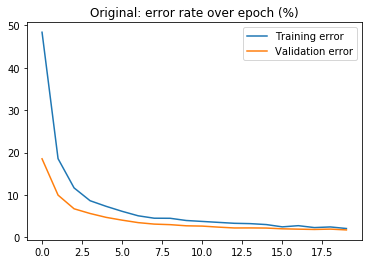

In [30]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Original: error rate over epoch (%)")
plt.show()

First layer image estimation:

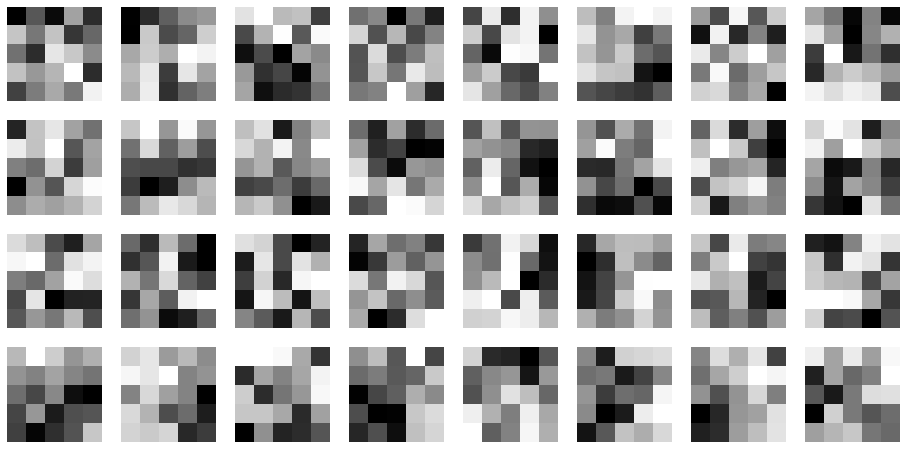

In [13]:
first_layer = net.conv1.weight
first_layer = first_layer.detach().numpy()
show_image(first_layer, 4, 8)

**Part (b):**  
For each experiment, aside from the plots, results are reported in terms of error rates at the max epoch (since they are expected to generally decrease as epoch increases).  
Also, the first and last feature numbers (1, 10) are not edited due to the context of the dataset.

**(i) Same number of layers:**  
Note: although (1) and (2) would not result in (approximately) doubled or halved number of parameters of the **entirety** of the model, they will still serve the purpose of checking the effects of change in parameter numbers.

(1) Double the number of parameters/features (in each layer): **"Double"**

In [14]:
feature_dim_double = (1, 32*2, 64*2, 1024*2, 256*2, 10)
net_double = MNIST_Net(feature_dim_double, p = dropout_p, minimizer=minimizer)
net_double.to(device)

MNIST_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [15]:
train_error, val_error = [], []

for i in range(num_epochs):
    
    run_epoch(net_double,i,train,batch_size, num=numtrain, ttype="train")
    net_test(net_double,val,batch_size)

100%|██████████| 10000/10000 [00:17<00:00, 565.61it/s, loss=0.0156]


In [16]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 0.80% | Validation set error 1.61%


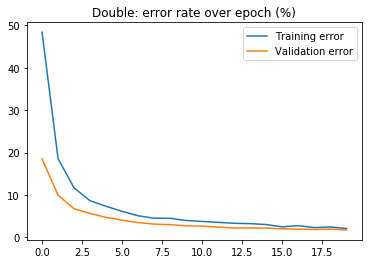

In [31]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Double: error rate over epoch (%)")
plt.show()

(2) Half the number of parameters/features (in each layer): **"Half"**

In [18]:
feature_dim_half = (1, 16, 32, 512, 128, 10)
net_half = MNIST_Net(feature_dim_half, p = dropout_p, minimizer=minimizer)
net_half.to(device)

MNIST_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [19]:
train_error, val_error = [], []

for i in range(num_epochs):
    
    run_epoch(net_half,i,train,batch_size, num=numtrain, ttype="train")
    net_test(net_half,val,batch_size)

100%|██████████| 10000/10000 [00:02<00:00, 3755.12it/s, loss=0.0889]


In [20]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 3.54% | Validation set error 2.43%


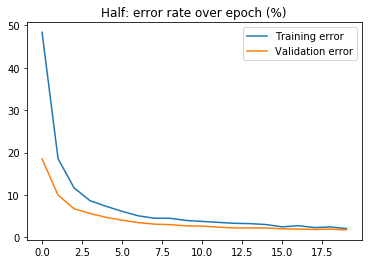

In [32]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Half: error rate over epoch (%)")
plt.show()

(3) Double numbers of parameters/features in convolutional layers & Half in fully-connected layers: **"Double-half"**

In [22]:
feature_dim_doublehalf = (1, 64, 128, 2048, 128, 10)
net_doublehalf = MNIST_Net(feature_dim_doublehalf, p = dropout_p, minimizer=minimizer)
net_doublehalf.to(device)

MNIST_Net(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [23]:
train_error, val_error = [], []

for i in range(num_epochs):
    
    run_epoch(net_doublehalf,i,train,batch_size, num=numtrain, ttype="train")
    net_test(net_doublehalf,val,batch_size)

100%|██████████| 10000/10000 [00:17<00:00, 578.80it/s, loss=0.0331]


In [24]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 1.81% | Validation set error 1.72%


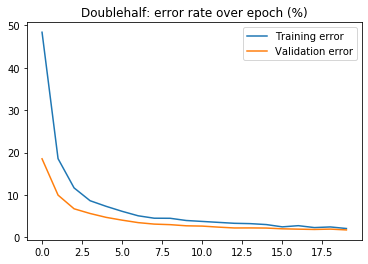

In [33]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Doublehalf: error rate over epoch (%)")
plt.show()

(4) Half numbers of parameters/features in convolutional layers & Double in fully-connected layers: **"Half-double"**

In [26]:
feature_dim_halfdouble = (1, 16, 32, 512, 512, 10)
net_halfdouble = MNIST_Net(feature_dim_halfdouble, p = dropout_p, minimizer=minimizer)
net_halfdouble.to(device)

MNIST_Net(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [27]:
train_error, val_error = [], []

for i in range(num_epochs):
    
    run_epoch(net_halfdouble,i,train,batch_size, num=numtrain, ttype="train")
    net_test(net_halfdouble,val,batch_size)

100%|██████████| 10000/10000 [00:02<00:00, 3549.07it/s, loss=0.0479]


In [28]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 2.10% | Validation set error 1.77%


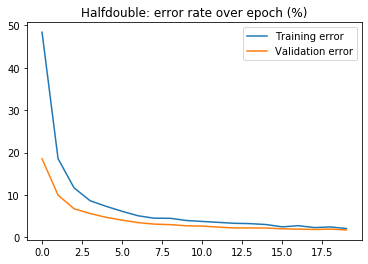

In [34]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Halfdouble: error rate over epoch (%)")
plt.show()

**(ii) Deeper network with similar number of parameters: "Deep"**

In (i), "Double" yielded the best result, and "Double-half" yielded the second best result. Based on this, I inferred that more parameters in convolutional (rather than fully-connected) layers would contribute more to the model performance.  

Therefore, I designed a deeper model with 3 convolutional layers and 2 fully-connected layers, which is presented as MNIST_Net_deep class below. Its number of parameters are as follows.

- conv1: 1 input, 32 outputs, kernel size 25 $\Rightarrow\space(1\times25+1)\times32=832$  
- conv2: 32 inputs, 64 outputs, kernel size 25 $\Rightarrow\space(32\times25+1)\times64=51,264$  
- conv3: 64 inputs, 256 outputs, kernel size 16 $\Rightarrow\space(64\times16+1)\times256=262,400$  
- fc1: 1024 inputs, 64 outputs $\Rightarrow(1024+1)\times64=65,600$  
- fc2: 64 inputs, 10 outputs $\Rightarrow(64+1)\times10=650$  

Hence, it has $832+51,264+262,400+65,600+650=380,746$ parameters. The original model is 317,066 parameters, so it is $(\frac{380,746}{317,066}-1)\times100\approx20\%$ more parameters than the original model. (a little more parameters)

In [35]:
class MNIST_Net_deep(nn.Module):
    '''
    Edited the original codes so that I can pass down feature numbers as parameters
    (deeper network version with fixed parameters)
    '''
    def __init__(self, p=0.5,minimizer='Adam'):
        
        super(MNIST_Net_deep, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding = 0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding = 0)
        self.conv3 = nn.Conv2d(64, 256, kernel_size = 4, padding = 0)
        self.conv2_drop = nn.Dropout2d(p)

        self.fc1 = nn.Linear(1024, 64)
        self.fc2 = nn.Linear(64, 10)
        
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
            
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
            
        self.first=True
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(self.conv2_drop(self.conv2(x)), 2)
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x
    
    def get_acc_and_loss(self, data, targ):

        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

In [36]:
net_deep = MNIST_Net_deep(p = dropout_p, minimizer=minimizer)
net_deep.to(device)
train_error, val_error = [], []

for i in range(num_epochs):
    
    run_epoch(net_deep,i,train,500, num=numtrain, ttype="train")
    net_test(net_deep,val,batch_size)

100%|██████████| 10000/10000 [00:12<00:00, 777.54it/s, loss=0.0648]


In [37]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 2.72% | Validation set error 2.16%


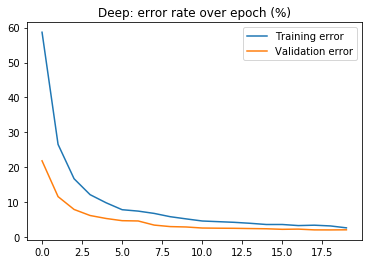

In [38]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Deep: error rate over epoch (%)")
plt.show()

**(iii) Best configuration**

Among experimented models above, (i)(2) (or "Double") yielded the best overall performance (0.80% training error, 1.61% validation error). Therefore, I chose "Double" as the best configuration to use here.

In [39]:
train_error, val_error = [], []

for i in range(num_epochs):
    run_epoch(net_double,i,train,500, num=50000, ttype="train") #full training set
    net_test(net_double,val,batch_size)

100%|██████████| 50000/50000 [01:33<00:00, 532.74it/s, loss=0.00597]


In [40]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 0.41% | Validation set error 0.55%


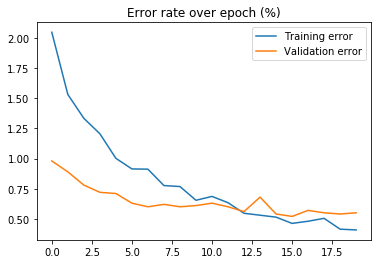

In [41]:
plt.plot(train_error)
plt.plot(val_error)
plt.legend(["Training error", "Validation error"])
plt.title("Error rate over epoch (%)")
plt.show()

The best configuration does amazing job on prediction, achieving extremely low error rates on both training and validation set (< 1%). The error rates as functions of epoch were still "generally monotone," matching the previous experiment results but with superb accuracy. In particular, as we now have 5 times more iterations (20 max. epoch with 5 times greater training set) than in the experiments, this would have led to the further accuracy of the model.

**Part (c):**

In [19]:
data_transform = np.float64(np.load('MNIST_TR.npy'))
data_transform = np.float32(data_transform)/255
    
train_transform = data_transform[0:50000].reshape((-1,1,28,28))
val_transform = data_transform[50000:60000].reshape((-1,1,28,28))
test_transform = data_transform[60000:70000].reshape((-1,1,28,28))

rng = np.random.default_rng()
sample_ind = rng.choice(50000, size = 10, replace = False)
sample_raw = train[0][sample_ind, 0, :, :]
sample_transform = train_transform[sample_ind, 0, :, :]

Original - transformed version comparison:

Sample original images


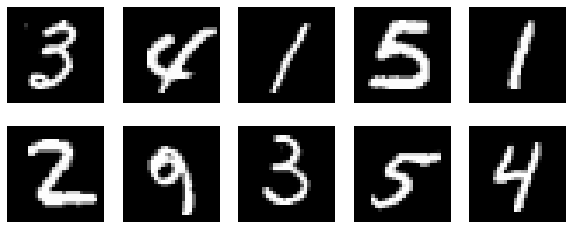

Sample transformed images


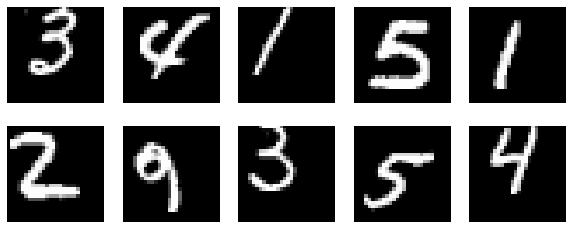

In [43]:
print("Sample original images")
show_image(sample_raw.reshape(10,1,28,28), 2, 5)
print("Sample transformed images")
show_image(sample_transform.reshape(10,1,28,28), 2, 5)

In [44]:
train_error, val_error = [], []

val_new = (val_transform, val[1])

for i in range(num_epochs):
    run_epoch(net_double,i,train,500, num=10000, ttype="train") #full training set
    net_test(net_deep,val_new,batch_size)

100%|██████████| 10000/10000 [00:18<00:00, 551.47it/s, loss=0.00314]


In [45]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 0.10% | Validation set error 56.04%


Even with the "Double" architecture (which yielded the best performance in part (b)), the model performed terribly: while error rate on the training set was tremendous (0.10%), its error rate on the validation set was worse than half, showing that this architecture is indeed lacks transformation-invariance.  

To make it more transformation-invariant, I made an edited version of the original model as below by increasing the kernel size, manipulating parameters for max_pool2d, and adjusting some feature numbers to match dimensions.

In [20]:
class MNIST_Net_transform(nn.Module):
    '''
    Edited the original codes so that I can pass down feature numbers as parameters
    (For-transformed data version with some parameters passed down from outside)
    '''
    def __init__(self, param, p=0.5,minimizer='Adam'):
        
        super(MNIST_Net_transform, self).__init__()
        
        self.param = param
        self.conv1 = nn.Conv2d(param[0], param[1], kernel_size=param[-4])
        self.conv2 = nn.Conv2d(param[1], param[2], kernel_size=param[-3])
        self.conv2_drop = nn.Dropout2d(p)
        self.fc1 = nn.Linear(param[3], param[4])
        self.fc2 = nn.Linear(param[4], param[5])
        
        if minimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), lr = step_size)
            
        else:
            self.optimizer = torch.optim.SGD(self.parameters(), lr = step_size, momentum=0.9)
            
        self.first=True
        self.criterion=nn.CrossEntropyLoss()
            
    def forward(self, x):

        x = F.relu(F.max_pool2d(self.conv1(x), self.param[-2]))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), self.param[-1]))
        x = x.view(-1, self.param[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        
        return x
    
    def get_acc_and_loss(self, data, targ):

        output = self.forward(data)
        loss = self.criterion(output, targ)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,targ).sum()
        
        return loss,correct
        
    def run_grad(self,data,targ):

        loss, correct=self.get_acc_and_loss(data,targ)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss, correct

Quick check on 10,000 training data and validation set:

In [22]:
feature_dim_tr = (1, 64, 128, 128, 256, 10, 9, 7, 2, 4)
net_transform = MNIST_Net_transform(feature_dim_tr, p = dropout_p, minimizer=minimizer)
net_transform.to(device)

train_error, val_error = [], []

#Experiment on 10,000 original training data and validation set
for i in range(num_epochs):
    run_epoch(net_transform,i,train,500, num=10000, ttype="train")
    net_test(net_transform,val_new,batch_size)

100%|██████████| 10000/10000 [00:16<00:00, 618.81it/s, loss=0.0556]


In [23]:
print("[At epoch = 20] Training set error {:.2f}% | Validation set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 2.78% | Validation set error 35.24%


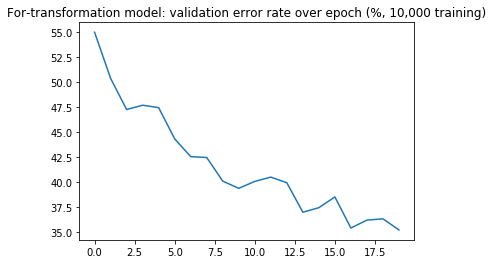

*Shows only validation error, for training error does not mean much in this context.


In [24]:
plt.plot(val_error)
plt.title("For-transformation model: validation error rate over epoch (%, 10,000 training)")
plt.show()
print("*Shows only validation error, for training error does not mean much in this context.")

Now, the fixed model shows 35.24% error rate on the transformed validation set. Although this might not be outstanding accuracy, it is still more than 20% decrease from the validation error rate of 56.04% by the previous ("Double") architecture. Considering that the "Double" architecture performed worse than 50-50 guess, it wowuld be a significant improvement in accuracy, and this model well deserves further examination on the full training and testing data.  



Examination of the model by training with original training + validation sets and testing on the transformed test set:

In [54]:
train_error, val_error = [], [] #val_error here is used as test error (since results are checked on the test set)

test_new = (test_transform, test[1])

for i in range(num_epochs):
    run_epoch(net_transform,i,train,500, num=50000, ttype="train")
    net_test(net_transform,test_new,batch_size)

100%|██████████| 50000/50000 [01:15<00:00, 664.94it/s, loss=0.0454] 


In [55]:
print("[At epoch = 20] Training set error {:.2f}% | Test set error {:.2f}%".format(train_error[-1], val_error[-1]))

[At epoch = 20] Training set error 0.77% | Test set error 17.41%


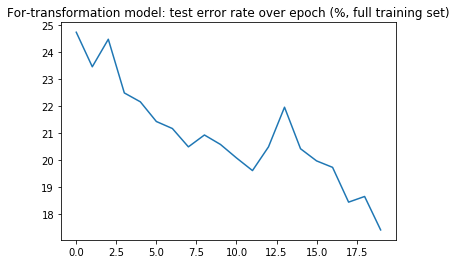

*Shows only test error, for training error does not mean much in this context.


In [56]:
plt.plot(val_error)
plt.title("For-transformation model: test error rate over epoch (%, full training set)")
plt.show()
print("*Shows only test error, for training error does not mean much in this context.")

Now, with the full training set, the fixed model recorded 17.41% error rate on the testing data. This is a meaningful improvement from the worse-than-50% error rate by the "Double" architecture, and even better than the fixed model's performance on the validation set (which is probably because the model underwent $5\times$ more iterations here).  
While the one-digit (or even below decimal) error rate was not be achieved, I determine that this fixed model performs sufficiently well on the transformed data with notably higher accuracy than simple random guess.